# Traditional ML: RandomForestClassifier

In [65]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

random_state = 77

In [2]:
!git clone https://github.com/ManaddaJ/BADS7604.git

Cloning into 'BADS7604'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 20 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [3]:
!pwd

/content


In [4]:
!ls

BADS7604  drive  sample_data


In [43]:
import pandas as pd
cust_df = pd.read_csv('/content/BADS7604/MLP/churn_localcontractor.csv')

In [6]:
cust_df

,id_360,first_to_last_three_yrs,recency_three_yrs,total_amt_three_yrs,no_order_three_yrs,active_mth,first_to_last_one_mth,active_day,total_amt_one_mth,no_order_one_mth,active_one_mth,first_to_last_three_mths,total_amt_three_mths,no_order_three_mths,active_three_mths,first_to_last_six_mths,total_amt_six_mths,no_order_six_mths,active_six_mths,first_to_last_twelve_mths,total_amt_twelve_mths,no_order_twelve_mths,active_twelve_mths,avg_revisit_duration_one_mth,std_revisit_duration_one_mth,avg_revisit_duration_three_yrs,std_revisit_duration_three_yrs,avg_revisit_duration_three_mths,std_revisit_duration_three_mths,avg_revisit_duration_six_mths,std_revisit_duration_six_mths,avg_revisit_duration_twelve_mths,std_revisit_duration_twelve_mths,is_churn
0,516016,472,207,375436.05,36,11,0,0,0.0,0,0,0,0.00,0,0,15,67405.91,8,2,212,184942.91,19,6,0.000000,0.000000,31.466667,32.323955,0.00000,0.000000,15.000000,0.000000,30.285714,25.322679,1
1,701820,1,1042,7435.00,2,1,0,0,0.0,0,0,0,0.00,0,0,0,0.00,0,0,0,0.00,0,0,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,514791,555,586,46222.43,7,4,0,0,0.0,0,0,0,0.00,0,0,0,0.00,0,0,0,0.00,0,0,0.000000,0.000000,92.500000,169.302983,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,627785,701,328,582.00,4,3,0,0,0.0,0,0,0,0.00,0,0,0,0.00,0,0,0,73.00,1,1,0.000000,0.000000,233.666667,257.070678,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,644791,50,634,3149.52,2,2,0,0,0.0,0,0,0,0.00,0,0,0,0.00,0,0,0,0.00,0,0,0.000000,0.000000,50.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45870,364096,636,95,1695668.43,111,19,0,0,0.0,0,0,55,291839.00,7,2,140,511602.10,20,5,303,901058.47,43,11,0.000000,0.000000,11.357143,12.193036,11.00000,6.324555,10.769231,9.959534,11.653846,8.917140,0
45871,704474,0,0,0.00,0,0,0,0,0.0,0,0,0,0.00,0,0,0,0.00,0,0,0,0.00,0,0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0
45872,300983,422,534,1553755.89,231,15,0,0,0.0,0,0,0,0.00,0,0,0,0.00,0,0,0,0.00,0,0,0.000000,0.000000,3.403226,4.252057,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1
45873,31331,536,61,1946934.84,270,19,30,10,30448.0,15,2,91,88232.48,44,4,181,204059.11,116,7,364,1099520.74,210,13,3.333333,4.924429,3.248485,3.806935,3.37037,3.991801,2.661765,2.904501,2.843750,2.759201,0


In [48]:
churn_df = cust_df.copy()
churn_df = churn_df.fillna(0)
churn_df.head()

,id_360,first_to_last_three_yrs,recency_three_yrs,total_amt_three_yrs,no_order_three_yrs,active_mth,first_to_last_one_mth,active_day,total_amt_one_mth,no_order_one_mth,active_one_mth,first_to_last_three_mths,total_amt_three_mths,no_order_three_mths,active_three_mths,first_to_last_six_mths,total_amt_six_mths,no_order_six_mths,active_six_mths,first_to_last_twelve_mths,total_amt_twelve_mths,no_order_twelve_mths,active_twelve_mths,avg_revisit_duration_one_mth,std_revisit_duration_one_mth,avg_revisit_duration_three_yrs,std_revisit_duration_three_yrs,avg_revisit_duration_three_mths,std_revisit_duration_three_mths,avg_revisit_duration_six_mths,std_revisit_duration_six_mths,avg_revisit_duration_twelve_mths,std_revisit_duration_twelve_mths,is_churn
0,516016,472,207,375436.05,36,11,0,0,0.0,0,0,0,0.0,0,0,15,67405.91,8,2,212,184942.91,19,6,0.0,0.0,31.466667,32.323955,0.0,0.0,15.0,0.0,30.285714,25.322679,1
1,701820,1,1042,7435.00,2,1,0,0,0.0,0,0,0,0.0,0,0,0,0.00,0,0,0,0.00,0,0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1
2,514791,555,586,46222.43,7,4,0,0,0.0,0,0,0,0.0,0,0,0,0.00,0,0,0,0.00,0,0,0.0,0.0,92.500000,169.302983,0.0,0.0,0.0,0.0,0.000000,0.000000,1
3,627785,701,328,582.00,4,3,0,0,0.0,0,0,0,0.0,0,0,0,0.00,0,0,0,73.00,1,1,0.0,0.0,233.666667,257.070678,0.0,0.0,0.0,0.0,0.000000,0.000000,1
4,644791,50,634,3149.52,2,2,0,0,0.0,0,0,0,0.0,0,0,0,0.00,0,0,0,0.00,0,0,0.0,0.0,50.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1


In [8]:
churn_df.columns

Index(['id_360', 'first_to_last_three_yrs', 'recency_three_yrs',
       'total_amt_three_yrs', 'no_order_three_yrs', 'active_mth',
       'first_to_last_one_mth', 'active_day', 'total_amt_one_mth',
       'no_order_one_mth', 'active_one_mth', 'first_to_last_three_mths',
       'total_amt_three_mths', 'no_order_three_mths', 'active_three_mths',
       'first_to_last_six_mths', 'total_amt_six_mths', 'no_order_six_mths',
       'active_six_mths', 'first_to_last_twelve_mths', 'total_amt_twelve_mths',
       'no_order_twelve_mths', 'active_twelve_mths',
       'avg_revisit_duration_one_mth', 'std_revisit_duration_one_mth',
       'avg_revisit_duration_three_yrs', 'std_revisit_duration_three_yrs',
       'avg_revisit_duration_three_mths', 'std_revisit_duration_three_mths',
       'avg_revisit_duration_six_mths', 'std_revisit_duration_six_mths',
       'avg_revisit_duration_twelve_mths', 'std_revisit_duration_twelve_mths',
       'is_churn'],
      dtype='object')

(45875, 34)
class 0: 29156
class 1: 16719


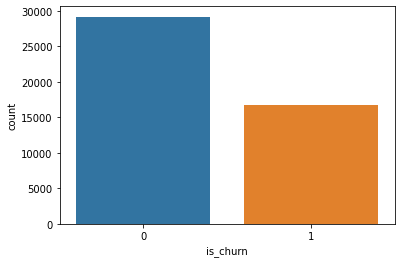

In [9]:
print(churn_df.shape)
print('class 0:', str(len(churn_df[churn_df['is_churn'] == 0])))
print('class 1:', str(len(churn_df[churn_df['is_churn'] == 1])))
sns.countplot(x='is_churn',data=churn_df)

In [10]:
def under_sampling(train_set_df, target, random_state):
    df_majority = train_set_df[train_set_df[target]==0]
    df_minority = train_set_df[train_set_df[target]==1]

    df_majority_downsampled = resample( df_majority, 
                                        n_samples = df_minority.shape[0], 
                                        replace=True, 
                                        random_state=random_state)

    train_set_df_ds = pd.concat([df_majority_downsampled, df_minority])
    return train_set_df_ds

def over_sampling(train_set_df, target, random_state):
    df_majority = train_set_df[train_set_df[target]==0]
    df_minority = train_set_df[train_set_df[target]==1]

    df_minority_oversampled = resample( df_minority, 
                                        n_samples = df_majority.shape[0], 
                                        replace=True, 
                                        random_state=random_state)

    train_set_df_ds = pd.concat([df_minority_oversampled, df_majority])
    return train_set_df_ds

## kFold to compare accuracy undersampling vs oversampling

### undersampling

In [11]:
# train_df.iloc[:,1:-1]
X, y = churn_df.iloc[:,1:-1], churn_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = random_state)
train_under = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

(22404, 33)
class 0: 11202
class 1: 11202


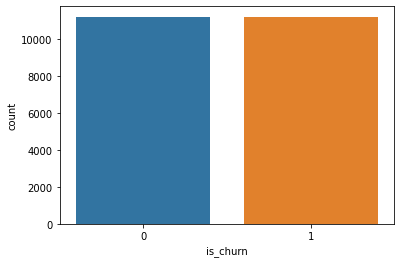

In [12]:
train_under = under_sampling(train_under, "is_churn", random_state)
print(train_under.shape)
print('class 0:', str(len(train_under[train_under['is_churn'] == 0])))
print('class 1:', str(len(train_under[train_under['is_churn'] == 1])))
sns.countplot(x='is_churn',data=train_under)

In [13]:
X_train, y_train = train_under.iloc[:,1:-1], train_under.iloc[:,-1]
# Create an instance of Pipeline
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=4))

# Create an instance of StratifiedKFold which can be used to get indices of different training and test folds
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)
scores = []
#
for k, (train, test) in enumerate(kfold):
    pipeline.fit(X_train.iloc[train, :], y_train.iloc[train])
    score = pipeline.score(X_train.iloc[test, :], y_train.iloc[test])
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [10081 10082], Accuracy: 0.930
Fold:  2, Training/Test Split Distribution: [10081 10082], Accuracy: 0.941
Fold:  3, Training/Test Split Distribution: [10082 10081], Accuracy: 0.932
Fold:  4, Training/Test Split Distribution: [10082 10081], Accuracy: 0.932
Fold:  5, Training/Test Split Distribution: [10082 10082], Accuracy: 0.929
Fold:  6, Training/Test Split Distribution: [10082 10082], Accuracy: 0.934
Fold:  7, Training/Test Split Distribution: [10082 10082], Accuracy: 0.929
Fold:  8, Training/Test Split Distribution: [10082 10082], Accuracy: 0.938
Fold:  9, Training/Test Split Distribution: [10082 10082], Accuracy: 0.932
Fold: 10, Training/Test Split Distribution: [10082 10082], Accuracy: 0.934


Cross-Validation accuracy: 0.933 +/- 0.003


### oversampling

In [14]:
X_churn, y_churn = churn_df.iloc[:,1:-1], churn_df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X_churn, y_churn, test_size=0.33, random_state = random_state)
train_over = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)

(39068, 33)
class 0: 19534
class 1: 19534


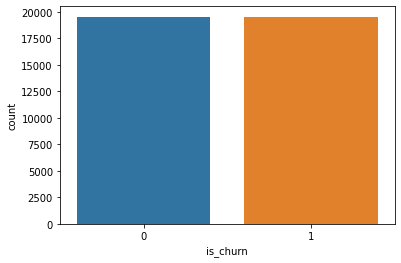

In [15]:
train_over = over_sampling(train_over, "is_churn", random_state)
print(train_over.shape)
print('class 0:', str(len(train_over[train_over['is_churn'] == 0])))
print('class 1:', str(len(train_over[train_over['is_churn'] == 1])))
sns.countplot(x='is_churn',data=train_over)

In [16]:
X_train, y_train = train_over.iloc[:,1:-1], train_over.iloc[:,-1]
# Create an instance of Pipeline
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=4))

# Create an instance of StratifiedKFold which can be used to get indices of different training and test folds
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)
scores = []
#
for k, (train, test) in enumerate(kfold):
    pipeline.fit(X_train.iloc[train, :], y_train.iloc[train])
    score = pipeline.score(X_train.iloc[test, :], y_train.iloc[test])
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [17581 17580], Accuracy: 0.930
Fold:  2, Training/Test Split Distribution: [17581 17580], Accuracy: 0.934
Fold:  3, Training/Test Split Distribution: [17581 17580], Accuracy: 0.932
Fold:  4, Training/Test Split Distribution: [17581 17580], Accuracy: 0.927
Fold:  5, Training/Test Split Distribution: [17580 17581], Accuracy: 0.929
Fold:  6, Training/Test Split Distribution: [17580 17581], Accuracy: 0.928
Fold:  7, Training/Test Split Distribution: [17580 17581], Accuracy: 0.927
Fold:  8, Training/Test Split Distribution: [17580 17581], Accuracy: 0.938
Fold:  9, Training/Test Split Distribution: [17581 17581], Accuracy: 0.935
Fold: 10, Training/Test Split Distribution: [17581 17581], Accuracy: 0.937


Cross-Validation accuracy: 0.932 +/- 0.004


## choose undersampling with high accuracy and low variance

In [53]:
# X, y = churn_df.iloc[:,1:-1], churn_df.iloc[:,-1]
train , test = train_test_split(churn_df , stratify=churn_df['is_churn'], test_size=0.33, random_state = random_state)
print(train.shape , test.shape)

under_df = under_sampling(train, "is_churn", random_state)
print(under_df.shape)

X_train , y_train  = under_df.iloc[:,1:-1], under_df.iloc[:,-1]
X_test , y_test    = test.iloc[:,1:-1], test.iloc[:,-1]

(30736, 34) (15139, 34)
(22404, 34)


In [57]:
rf = RandomForestClassifier(n_estimators=10, random_state=random_state)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=77)

In [58]:
y_train_pred = rf.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11202
           1       1.00      0.98      0.99     11202

    accuracy                           0.99     22404
   macro avg       0.99      0.99      0.99     22404
weighted avg       0.99      0.99      0.99     22404



In [59]:
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      9622
           1       0.85      0.95      0.90      5517

    accuracy                           0.92     15139
   macro avg       0.91      0.93      0.91     15139
weighted avg       0.92      0.92      0.92     15139



In [60]:
print(y_train.value_counts(), '\n' , y_test.value_counts())

1    11202
0    11202
Name: is_churn, dtype: int64 
 0    9622
1    5517
Name: is_churn, dtype: int64


###Confusion Matrix

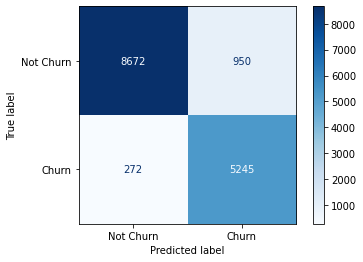

In [66]:
labels = ['Not Churn', 'Churn']
cm  = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.savefig('confusion_matrix.png')
plt.show()

### model result

In [61]:
all_X = churn_df.iloc[:,1:-1]
all_y = churn_df.iloc[:,-1]

In [62]:
all_y_pred = rf.predict(all_X)
all_y_pred_prob = rf.predict_proba(all_X)

churn_df_with_predict = churn_df.copy()
churn_df_with_predict['churn_pred'] = all_y_pred
churn_df_with_predict['churn_pred_prob'] = all_y_pred_prob[:,1]

print(classification_report(all_y, all_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95     29156
           1       0.89      0.97      0.93     16719

    accuracy                           0.94     45875
   macro avg       0.93      0.95      0.94     45875
weighted avg       0.95      0.94      0.94     45875



In [63]:
print(all_y.value_counts(), '\n' , churn_df_with_predict['churn_pred'].value_counts())

0    29156
1    16719
Name: is_churn, dtype: int64 
 0    27552
1    18323
Name: churn_pred, dtype: int64


### feature importance

Text(0.5, 0, 'Random Forest Feature Importance')

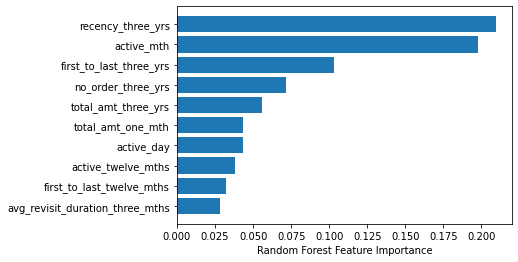

In [64]:
sorted_idx = rf.feature_importances_.argsort()[-10:]
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")